<a href="https://colab.research.google.com/github/shabbirk53/DSML/blob/main/Superconductor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import RandomizedSearchCV as RandomCV

In [25]:
df = pd.read_csv('/content/train.csv')

df

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


<Axes: >

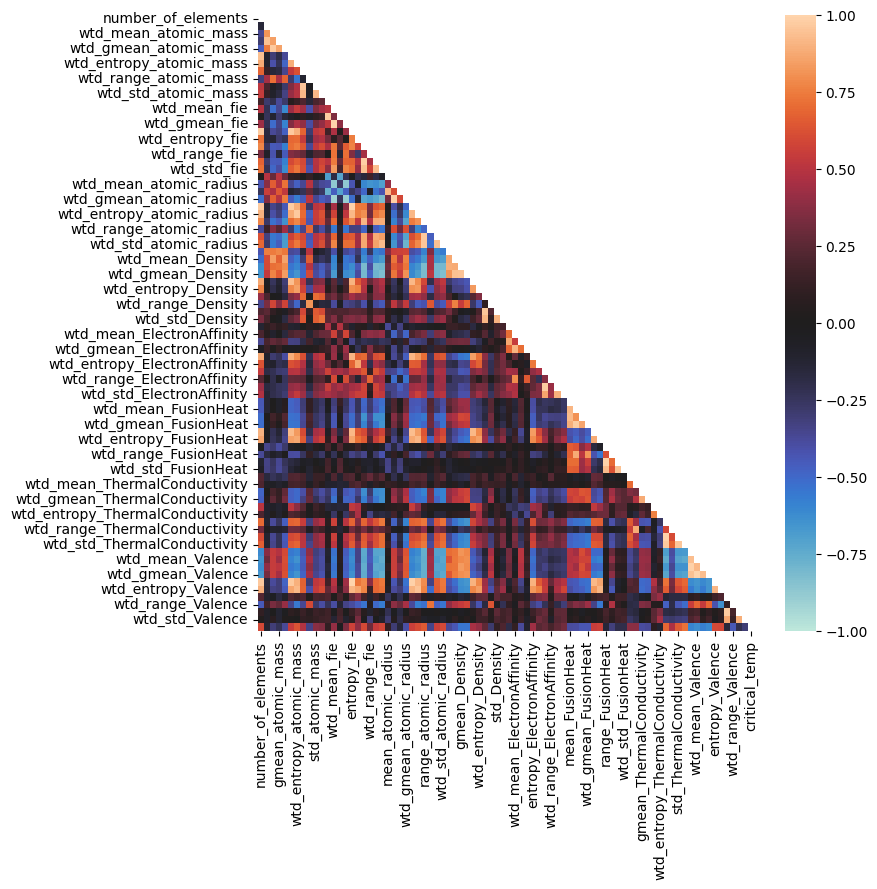

In [56]:
plt.figure(figsize=(8, 8))

mask = np.triu(np.ones(df.corr().shape)).astype(bool)
sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap='icefire')

In [57]:
corr_df = df.corr()
targ = 'critical_temp'
corc_targ = corr_df[targ]

high_corr_var = []
print("High correlated variables with target:")
for i, pearson in corc_targ.items():
    if i != targ and pearson >= 0.5:
        print(f'{i}: {pearson:.3f}')
        high_corr_var.append(i)


High correlated variables with target:
number_of_elements: 0.601
entropy_atomic_mass: 0.544
wtd_entropy_atomic_mass: 0.627
entropy_fie: 0.568
range_fie: 0.601
std_fie: 0.542
wtd_std_fie: 0.582
entropy_atomic_radius: 0.559
wtd_entropy_atomic_radius: 0.603
range_atomic_radius: 0.654
std_atomic_radius: 0.560
wtd_std_atomic_radius: 0.599
entropy_FusionHeat: 0.553
wtd_entropy_FusionHeat: 0.563
range_ThermalConductivity: 0.688
std_ThermalConductivity: 0.654
wtd_std_ThermalConductivity: 0.721
entropy_Valence: 0.599
wtd_entropy_Valence: 0.590


<Axes: >

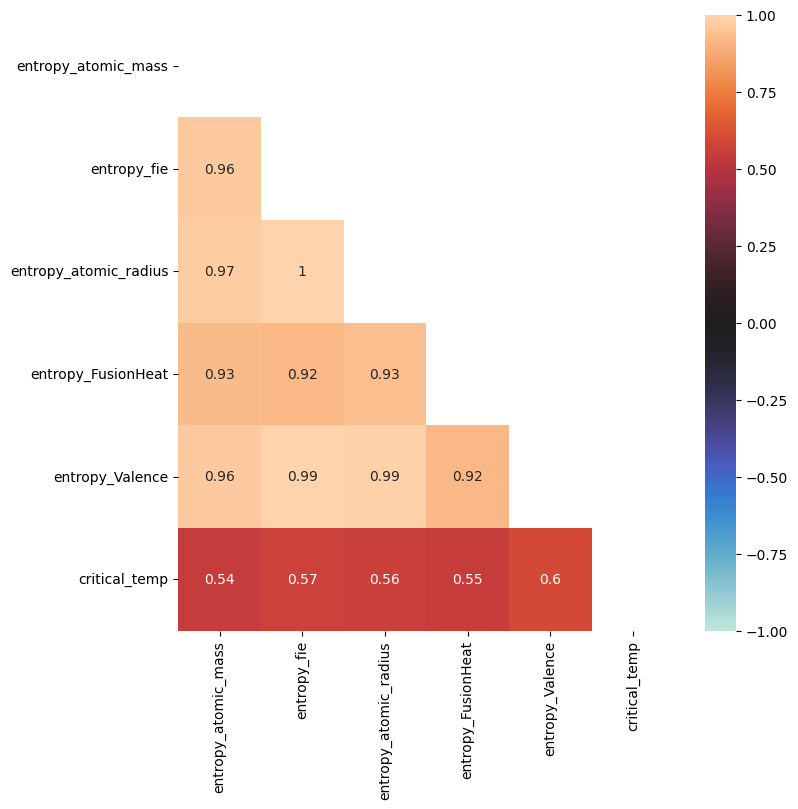

In [58]:
selected_features = ['entropy_atomic_mass', 'entropy_fie', 'entropy_atomic_radius', 'entropy_FusionHeat', 'entropy_Valence', 'critical_temp']
df_ = df[selected_features]

plt.figure(figsize=(8, 8))

corr = df_.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='icefire', annot=True)


Using PCA to reduce dimensionality

In [59]:
# Separate predictors and target
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Make pipeline of standard scaling and PCA
sc = StandardScaler()
pca = PCA()
pipe = make_pipeline(sc, pca)

# Fit pipeline on data
pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

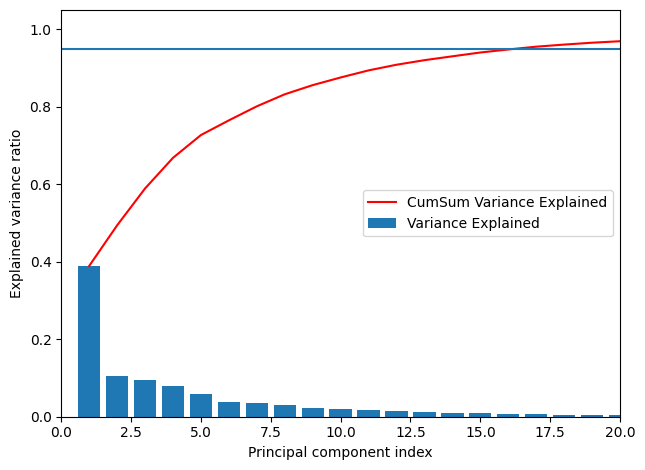

In [60]:
# Explained variance ratio
explained_ratio = pipe[1].explained_variance_ratio_

# Plot the variance ratio
nf = len(X.columns)
plt.bar(range(1,nf+1), explained_ratio, label='Variance Explained')
plt.plot(range(1,nf+1), np.cumsum(explained_ratio), label='CumSum Variance Explained', c='r')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.tight_layout()
plt.xlim(0,20)

# 95% variance threshold
plt.axhline(0.95)

plt.show()


predict the critical temperature using Random Forest regressor

In [61]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline
n_pca = 15
scaler = StandardScaler()
pca = PCA(n_pca, random_state=112)
model = RFR()
pipe = make_pipeline(scaler, pca, model)

# Cross-validation
cross_val_score(pipe, X_train, y_train, cv=5)

array([0.9103347 , 0.89802552, 0.89809554, 0.89358195, 0.90517449])

In [68]:
# Fit to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

print(f'Train R2: {pipe.score(X_train, y_train)}')
print(f'Test R2: {pipe.score(X_test, y_test)}')

Train R2: 0.9769298689826764
Test R2: 0.9096404974069485


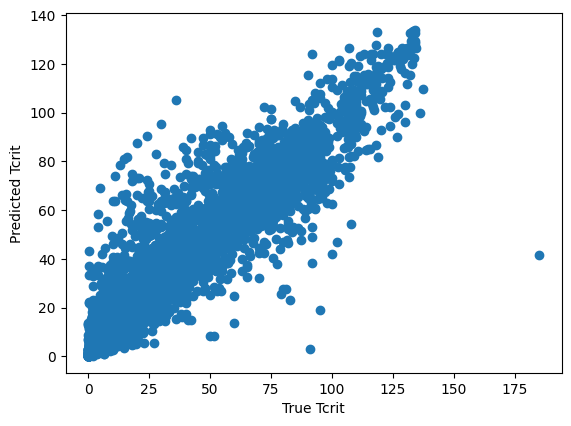

In [67]:
# True vs. Predicted plot
plt.scatter(y_test, y_pred)
plt.xlabel('True Tcrit')
plt.ylabel('Predicted Tcrit')
plt.gca().set_aspect('equal')

Hyperparameter tuning

In [70]:
pipe[2][1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 557391925,
 'splitter': 'best'}

In [71]:
# Randomized CV with 5-fold
param_grid = {'randomforestregressor__max_depth': [30, 50, 70],
              'randomforestregressor__min_samples_leaf': [2, 5, 10],
             'randomforestregressor__n_estimators': [400, 500, 600]}

rf_random = RandomCV(estimator=pipe, param_distributions=param_grid,
                  n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
# Fit to train set
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
# Best model parameters
rf_random.best_params_

In [ ]:
# Best model CV score
rf_random.best_score_

In [ ]:
# Predict on test set
y_pred = rf_random.predict(X_test)

print(f'Train R2: {rf_random.score(X_train, y_train)}')
print(f'Test R2: {rf_random.score(X_test, y_test)}')